# Context
This notebook is a simple example of how to use the Iris dataset to train a model using the [scikit-learn](https://scikit-learn.org/stable/) library.
ACP, CAH and K-means clustering are used to classify the data. These alogithms include three class that could be reused in other projects.
___

# Import des librairies

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

In [2]:
sns.set()

___

# Load the iris dataset

In [3]:
iris = datasets.load_iris(as_frame=True)

In [4]:
iris.data.head()

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2

In [5]:
target = iris.target
iris = iris.data
iris["target"]=target
iris

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                  5.1               3.5                1.4               0.2   
1                  4.9               3.0                1.4               0.2   
2                  4.7               3.2                1.3               0.2   
3                  4.6               3.1                1.5               0.2   
4                  5.0               3.6                1.4               0.2   
..                 ...               ...                ...               ...   
145                6.7               3.0                5.2               2.3   
146                6.3               2.5                5.0               1.9   
147                6.5               3.0                5.2               2.0   
148                6.2               3.4                5.4               2.3   
149                5.9               3.0                5.1               1.8   

     target  
0         0  
1         0  
2         0  
3         0  
4         0  
..      ...  
145       2  
146       2  
147       2  
148       2  
149       2  

[150 rows x 5 columns]

In [6]:
iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB


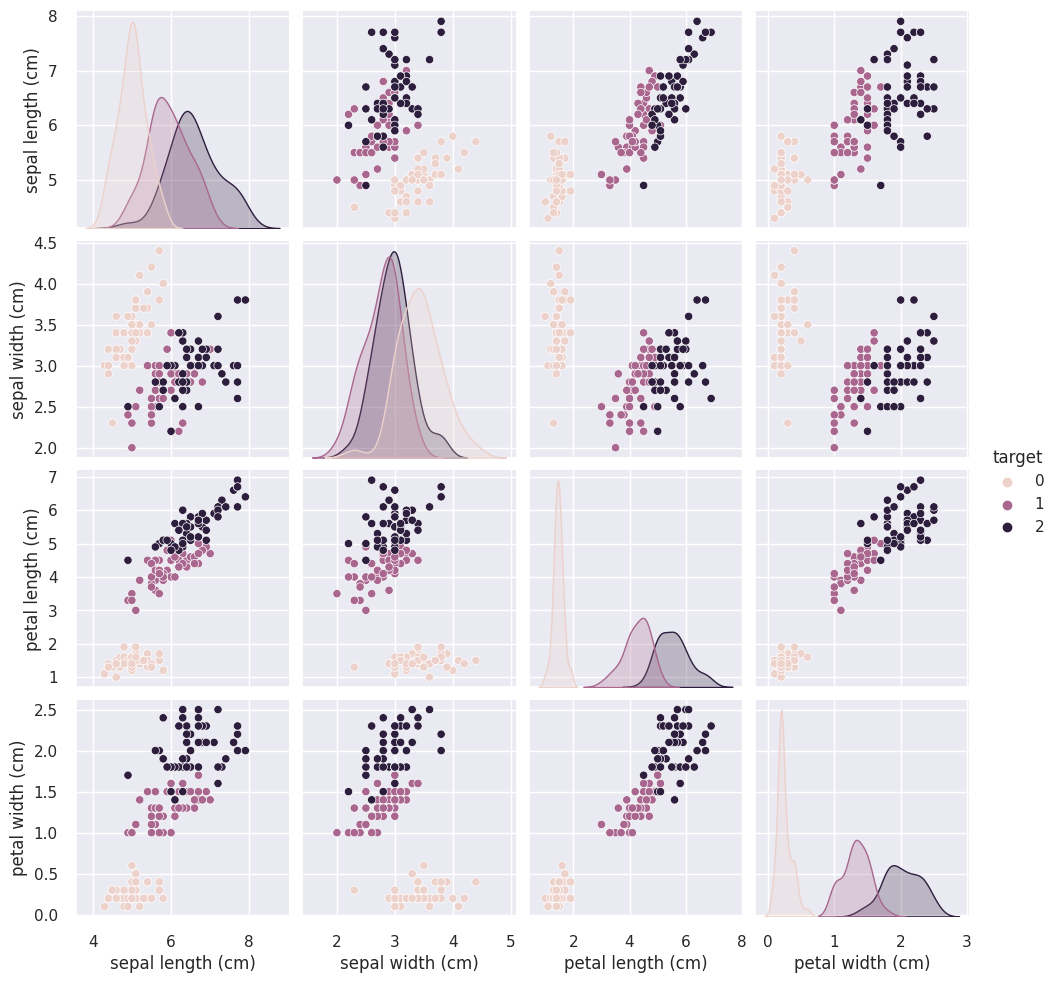

In [7]:
sns.pairplot(data=iris,kind='scatter',hue='target')

We drop the target column and will now proceed with clustering.

In [8]:
iris_values = iris.drop(columns=['target'])

# Correlation heatmap

<Axes: >

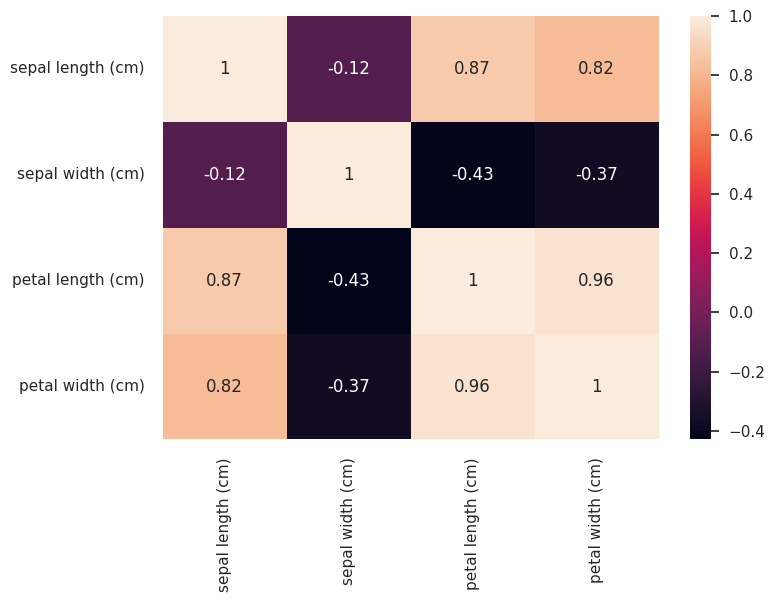

In [9]:
sns.heatmap(iris_values.corr(),annot=True)

We can see that we have a strong correlation between petal length and petal width. We can also see that we have a strong correlation between sepal length and sepal width. Petal length and sepal length are also correlated. This is not surprising as the iris flower is a symmetrical flower.

# PCA
## Class

In [49]:
class c_PCA :
    def __init__(self, df, columns, n_components=6):
        self.df = df[columns]
        self.columns = columns
        self.n_components = n_components
        self.X = self.df.values 
        self.X_scaled = None
        self.X_scaled_verif = None
        self.pca = None
        self.pcs = None
        
    def scale(self,scalertype):
        scaler = scalertype
        scaled_features = scaler.fit(self.X)
        self.X_scaled = scaled_features.transform(self.X)
        self.X_scaled_verif = pd.DataFrame(self.X_scaled).describe().round(2).loc[["mean", "std"], :]
    
    def pca_evr(self):
        self.pca = PCA(n_components=self.n_components)
        self.pca.fit(self.X_scaled)
        
        self.pcs = self.pca.components_
        self.pcs = pd.DataFrame(self.pcs, columns=self.columns)
        self.pcs.index = [f"F{i+1}" for i in range(self.n_components)]
        self.pcs = self.pcs.round(2)
        
        evr = (self.pca.explained_variance_ratio_*100).round(2)
        print("Explained variance ratio: ", evr)
        evr_cum = evr.cumsum().round()
        print("Cumulative explained variance ratio: ", evr_cum)
        
        x_list = range(1,self.n_components+1)
        
        plt.bar(x_list, evr)
        plt.plot(x_list, evr_cum,c="red",marker='o')
        plt.xlabel("rang de l'axe d'inertie")
        plt.ylabel("pourcentage d'inertie")
        plt.title("Eboulis des valeurs propres")
        plt.show(block=False)
        

    def correlation_circle(self,
                           ax,
                           x_y) : 
        """Affiche le graphe des correlations

        Positional arguments : 
        -----------------------------------
        pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
        x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
        features : list ou tuple : la liste des features (ie des dimensions) à représenter
        """

        # Extrait x et y 
        x,y=x_y

        # Pour chaque composante : 
        for i in range(0, self.pca.components_.shape[1]):

            # Les flèches
            ax.arrow(0,0, 
                    self.pca.components_[x, i],  
                    self.pca.components_[y, i],  
                    head_width=0.07,
                    head_length=0.07, 
                    width=0.02, )

            # Les labels
            plt.text(self.pca.components_[x, i] + 0.05,
                    self.pca.components_[y, i] + 0.05,
                    self.columns[i])
            
        # Affichage des lignes horizontales et verticales
        plt.plot([-1, 1], [0, 0], color='grey', ls='--')
        plt.plot([0, 0], [-1, 1], color='grey', ls='--')

        # Nom des axes, avec le pourcentage d'inertie expliqué
        plt.xlabel('F{} ({}%)'.format(x+1, round(100*self.pca.explained_variance_ratio_[x],1)))
        plt.ylabel('F{} ({}%)'.format(y+1, round(100*self.pca.explained_variance_ratio_[y],1)))

        # J'ai copié collé le code sans le lire
        plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

        # Le cercle 
        an = np.linspace(0, 2 * np.pi, 100)
        plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

        # Axes et display
        plt.axis('equal')
        plt.show(block=False)
        
        
    def display_factorial_planesi(self,x_y, ax,
                                labels = None,
                                clusters=None, 
                                alpha=1,
                                marker="." ):
        """
        Affiche la projection des individus

        Positional arguments : 
        -------------------------------------
        X_projected : np.array, pd.DataFrame, list of list : la matrice des points projetés
        x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2

        Optional arguments : 
        -------------------------------------
        pca : sklearn.decomposition.PCA : un objet PCA qui a été fit, cela nous permettra d'afficher la variance de chaque composante, default = None
        labels : list ou tuple : les labels des individus à projeter, default = None
        clusters : list ou tuple : la liste des clusters auquel appartient chaque individu, default = None
        alpha : float in [0,1] : paramètre de transparence, 0=100% transparent, 1=0% transparent, default = 1
        figsize : list ou tuple : couple width, height qui définit la taille de la figure en inches, default = [10,8] 
        marker : str : le type de marker utilisé pour représenter les individus, points croix etc etc, default = "."
        """

        X_projected = self.pca.transform(self.X_scaled)
        # Transforme X_projected en np.array
        X_ = np.array(X_projected)

        # On gère les labels
        if  labels is None : 
            labels = []
        try : 
            len(labels)
        except Exception as e : 
            raise e

        # On vérifie la variable axis 
        if not len(x_y) ==2 : 
            raise AttributeError("2 axes sont demandées")   
        if max(x_y )>= X_.shape[1] : 
            raise AttributeError("la variable axis n'est pas bonne")   

        # on définit x et y 
        x, y = x_y

        # On vérifie s'il y a des clusters ou non
        c = None if clusters is None else clusters
    
        # Les points    
        # plt.scatter(   X_[:, x], X_[:, y], alpha=alpha, 
        #                     c=c, cmap="Set1", marker=marker)
        sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c)

        # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe 
        v1 = str(round(100*self.pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*self.pca.explained_variance_ratio_[y]))  + " %"


        # Nom des axes, avec le pourcentage d'inertie expliqué
        ax.set_xlabel(f'F{x+1} {v1}')
        ax.set_ylabel(f'F{y+1} {v2}')

        # Valeur x max et y max
        x_max = np.abs(X_[:, x]).max() *1.1
        y_max = np.abs(X_[:, y]).max() *1.1

        # On borne x et y 
        ax.set_xlim(left=-x_max, right=x_max)
        ax.set_ylim(bottom= -y_max, top=y_max)

        # Affichage des lignes horizontales et verticales
        plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
        plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

        # Affichage des labels des points
        if len(labels) : 
            # j'ai copié collé la fonction sans la lire
            for i,(_x,_y) in enumerate(X_[:,[x,y]]):
                plt.text(_x, _y+0.05, labels[i], fontsize='14', ha='center',va='center') 

        # Titre et display
        plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")
        plt.show()
        
        

In [19]:
columns_to_study = iris_values.columns
pca = c_PCA(iris_values, columns_to_study)

In [50]:
pca.scale(StandardScaler())
pca.X_scaled_verif

0    1    2    3
mean -0.0 -0.0 -0.0 -0.0
std   1.0  1.0  1.0  1.0

In [51]:
columns_to_study = iris_values.columns
pca = c_PCA(iris_values, columns_to_study, n_components=4)
pca.scale(StandardScaler())
pca.X_scaled_verif

0    1    2    3
mean -0.0 -0.0 -0.0 -0.0
std   1.0  1.0  1.0  1.0

Explained variance ratio:  [72.96 22.85  3.67  0.52]
Cumulative explained variance ratio:  [ 73.  96.  99. 100.]


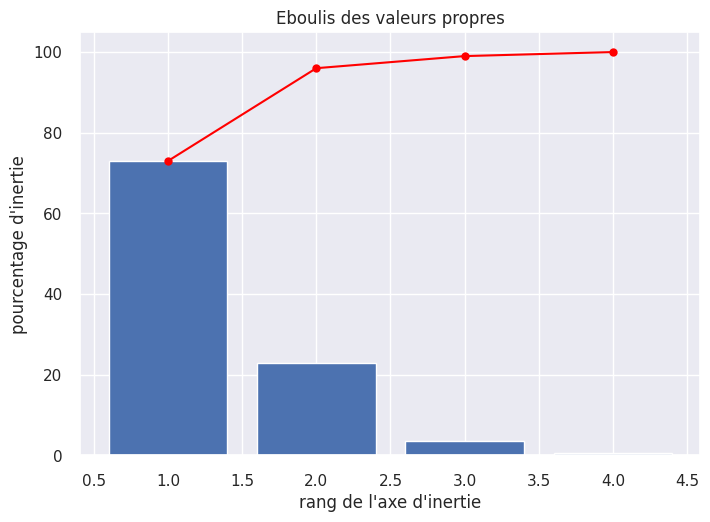

In [52]:
pca.pca_evr()

In [53]:
pca.pcs.T

F1    F2    F3    F4
sepal length (cm)  0.52  0.38 -0.72 -0.26
sepal width (cm)  -0.27  0.92  0.24  0.12
petal length (cm)  0.58  0.02  0.14  0.80
petal width (cm)   0.56  0.07  0.63 -0.52

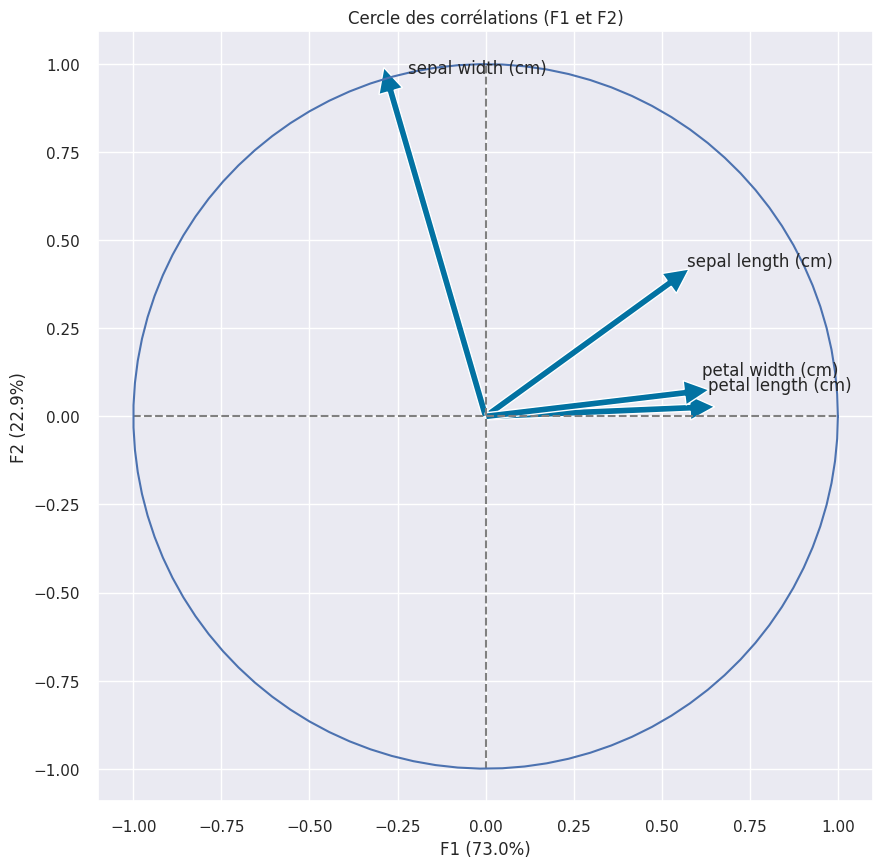

In [54]:
fig, ax = plt.subplots(figsize=(10,10))
x_y = (0,1)
pca.correlation_circle(ax,x_y)

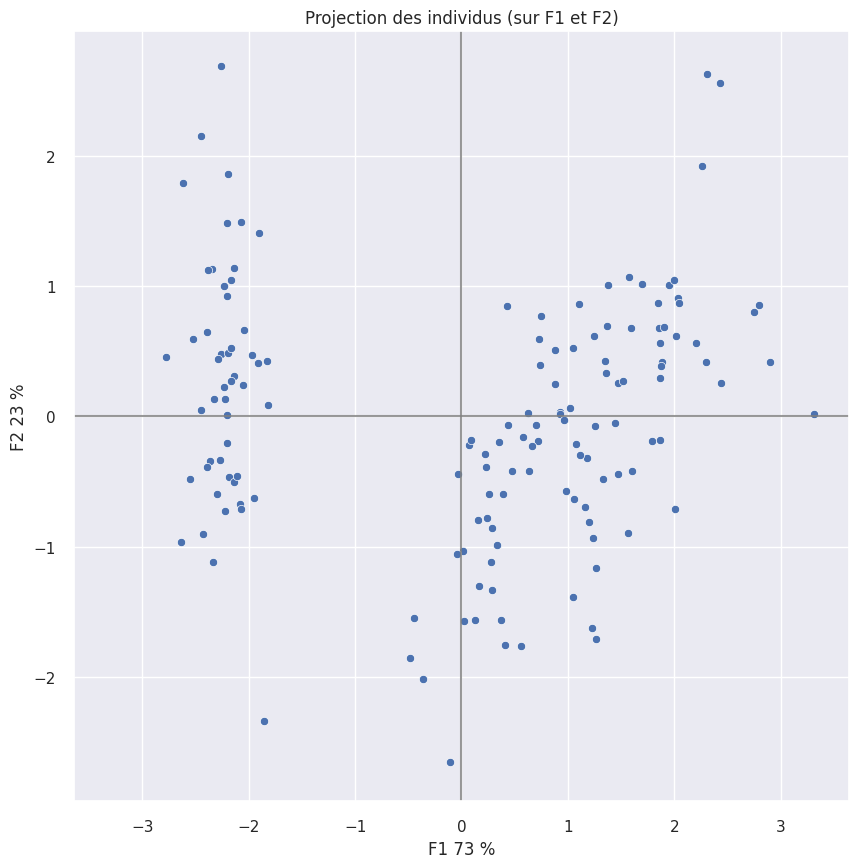

In [59]:
fig, ax = plt.subplots(figsize=(10,10))
x_y = (0,1)
pca.display_factorial_planesi(x_y, ax)

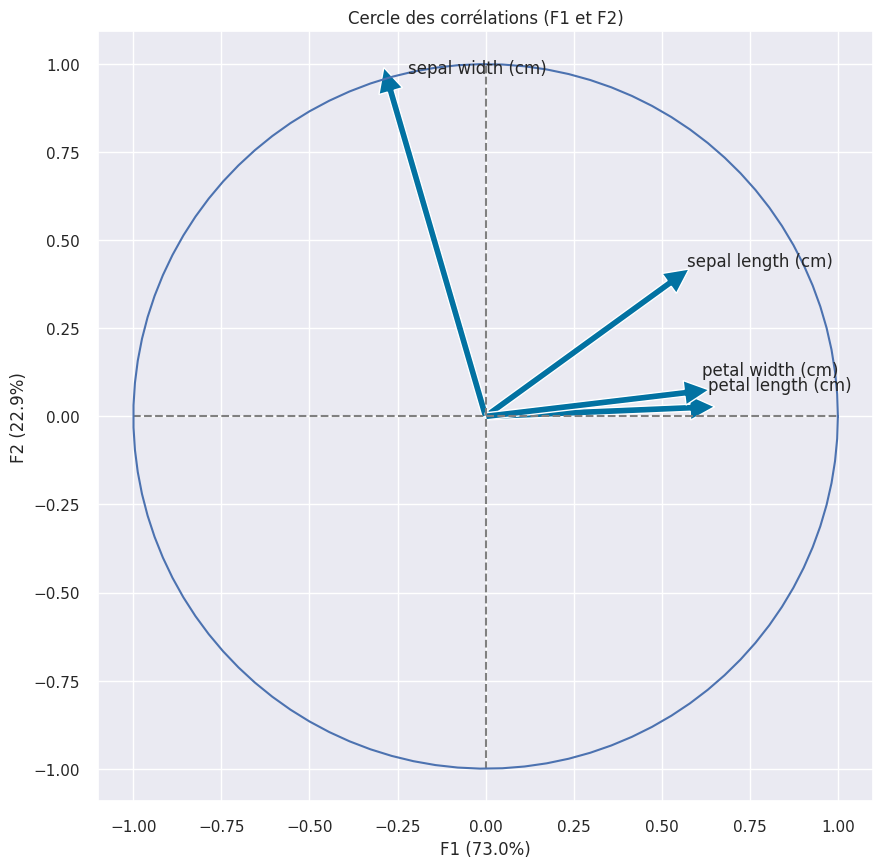

In [55]:
fig, ax = plt.subplots(figsize=(10,10))
x_y = (0,1)
pca.correlation_circle(ax,x_y)

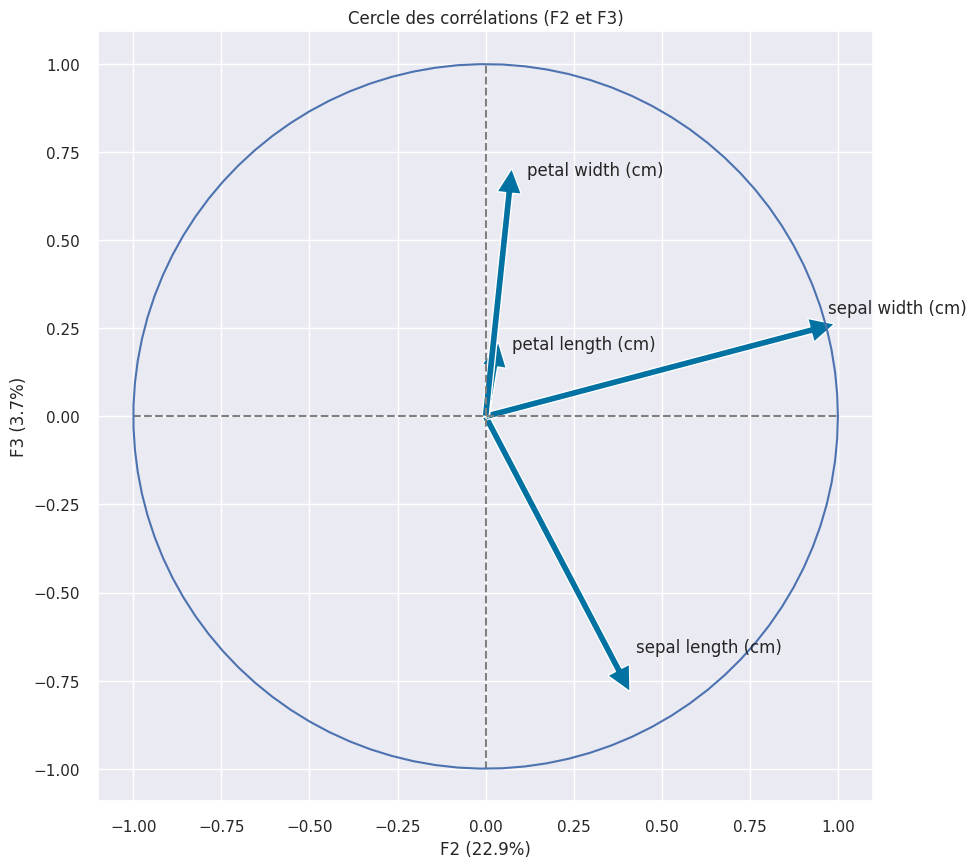

In [56]:
fig, ax = plt.subplots(figsize=(10,10))
x_y = (1,2)
pca.correlation_circle(ax,x_y)

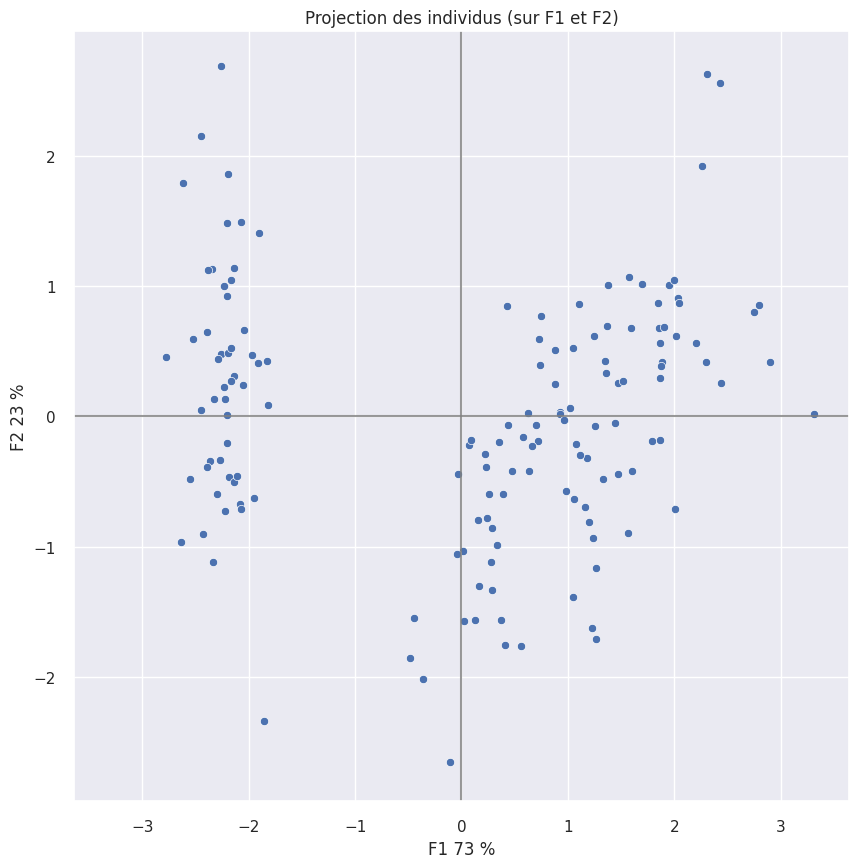

In [58]:
fig, ax = plt.subplots(figsize=(10,10))
x_y = (0,1)
pca.display_factorial_planesi(x_y, ax)

# CAH
## Class

In [53]:
class CAH :
    def __init__(self,df,columns):
        self.df = df[columns]
        self.colmuns = columns
        self.Z = None
        self.df_mean_std = None
        self.clusters = None
    
    def scale(self,scalertype : StandardScaler)->None:
        """
        This function scales the data using the scaler type provided as input. 
        We are also creating a short DataFrame with the mean and standard deviation of the scaled data.
        
        Parameters:
            scalertype (StandardScaler) : scaler type to use for scaling the data
        
        Returns:
            None
        """
        #Put values in the scaler, fit and transform
        X = self.df.values
        scaler = scalertype
        scaled_features = scaler.fit(X)
        X_scaled = scaled_features.transform(X)
        #Linkage using ward method
        self.Z = linkage(X_scaled, method='ward')
        # Short DataFrame with mean and std to verify the scaling
        self.df_mean_std = pd.DataFrame(X_scaled).describe().round(2).iloc[1:3:, : ]
        
    def dendrogram(self,ax,title,xlabel,ylabel,labelsize=5):
        '''This function plots the dendrogram. Subplot should be created before calling this function, providing the ax parameter.
            input: ax, title, xlabel, ylabel, labelsize
        '''
        _ = dendrogram(self.Z, ax=ax, labels=self.df.index, orientation = "left")
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.tick_params(axis='x', which='major', labelsize=labelsize)
        ax.tick_params(axis='y', which='major', labelsize=labelsize)
        
    def cluster(self,n_clusters):
        '''This function clusters the data using the number of clusters provided as input. This number is chosen by the user reviewing the dendogram.
            input: n_clusters
        '''
        clustering_model = AgglomerativeClustering(n_clusters=n_clusters, linkage = "ward")
        clustering_model.fit(self.df.values)
        self.clusters = clustering_model.labels_

## Usage

In [54]:
iris_values.head()

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2

## Clustering using only two features

We firstly choose two of the four features to cluster the data. No interest in that other than to provide a use case for the class.

In [55]:
columns_to_study = ['petal length (cm)','petal width (cm)']
cah_petal = CAH(iris_values,columns_to_study)

In [56]:
cah_petal.df.head()

petal length (cm)  petal width (cm)
0                1.4               0.2
1                1.4               0.2
2                1.3               0.2
3                1.5               0.2
4                1.4               0.2

We can now scale the data and verify that the scaling is correct by checking mean and standard deviation.

In [57]:
cah_petal.scale(StandardScaler())
cah_petal.df_mean_std

0    1
mean -0.0 -0.0
std   1.0  1.0

### First dendogram
We can now plot the first dendogram.

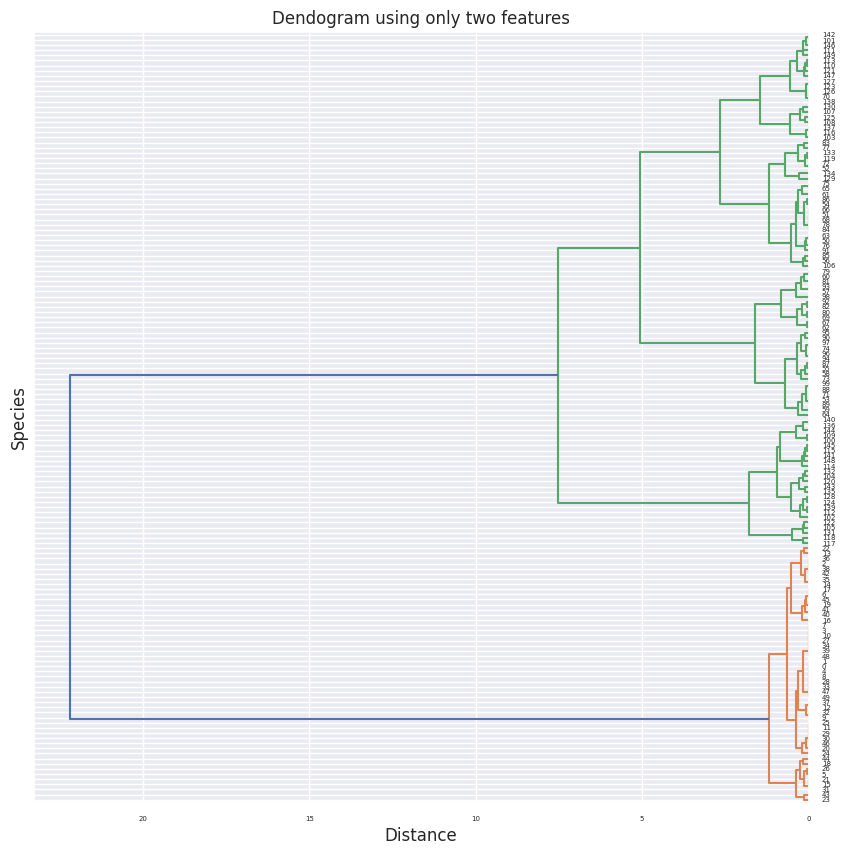

In [58]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
cah_petal.dendrogram(ax,"Dendogram using only two features","Distance","Species",labelsize=5)

We can clearly see three clusters. We can now compute the clusters using this information and add it to a Dataframe.

In [59]:
cah_petal.cluster(3)
cah_petal.clusters

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [60]:
iris_cah = iris_values.copy()
iris_cah["CAH_Petal"] = cah_petal.clusters
iris_cah.head()

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   CAH_Petal  
0          1  
1          1  
2          1  
3          1  
4          1

Text(0.5, 1.05, 'Iris dataset grouped by target value')

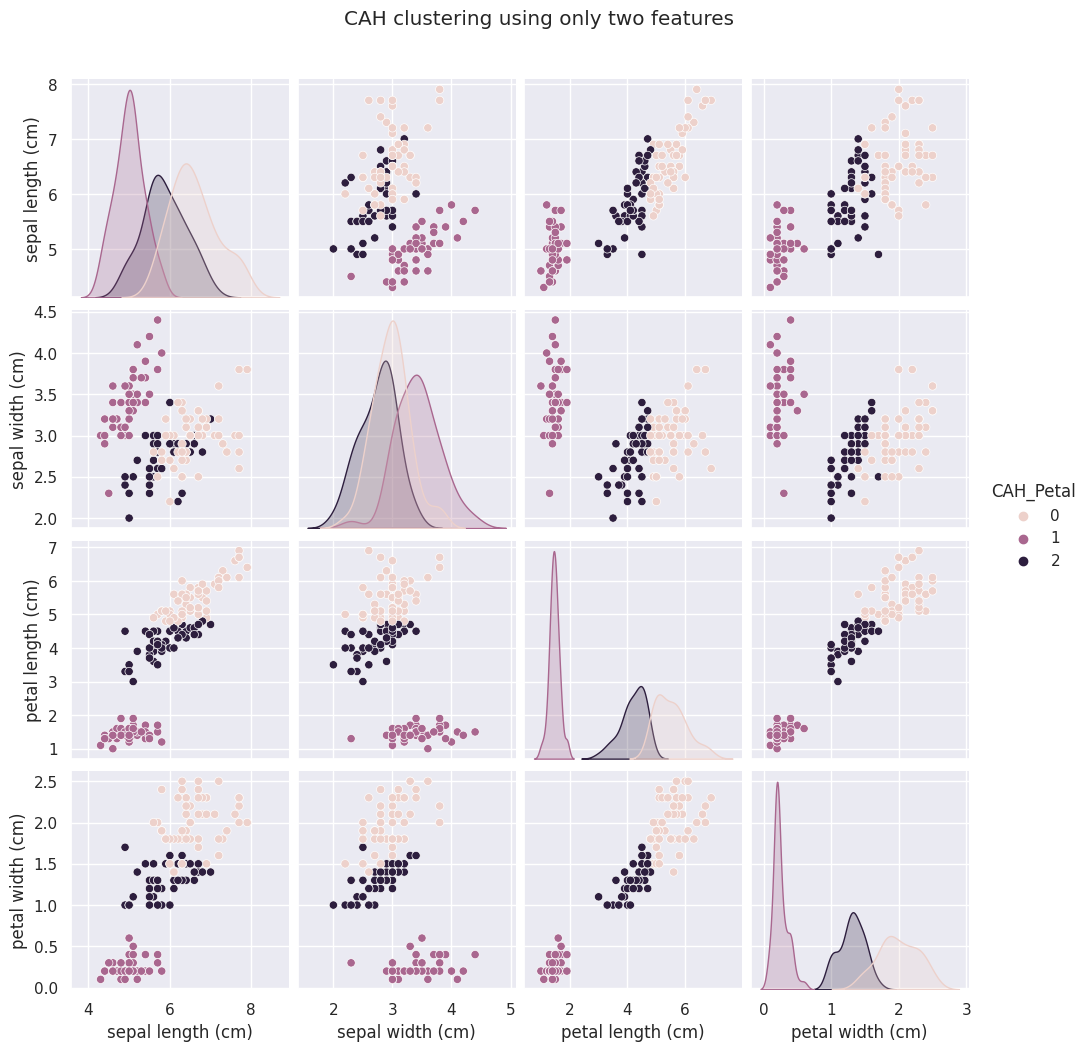

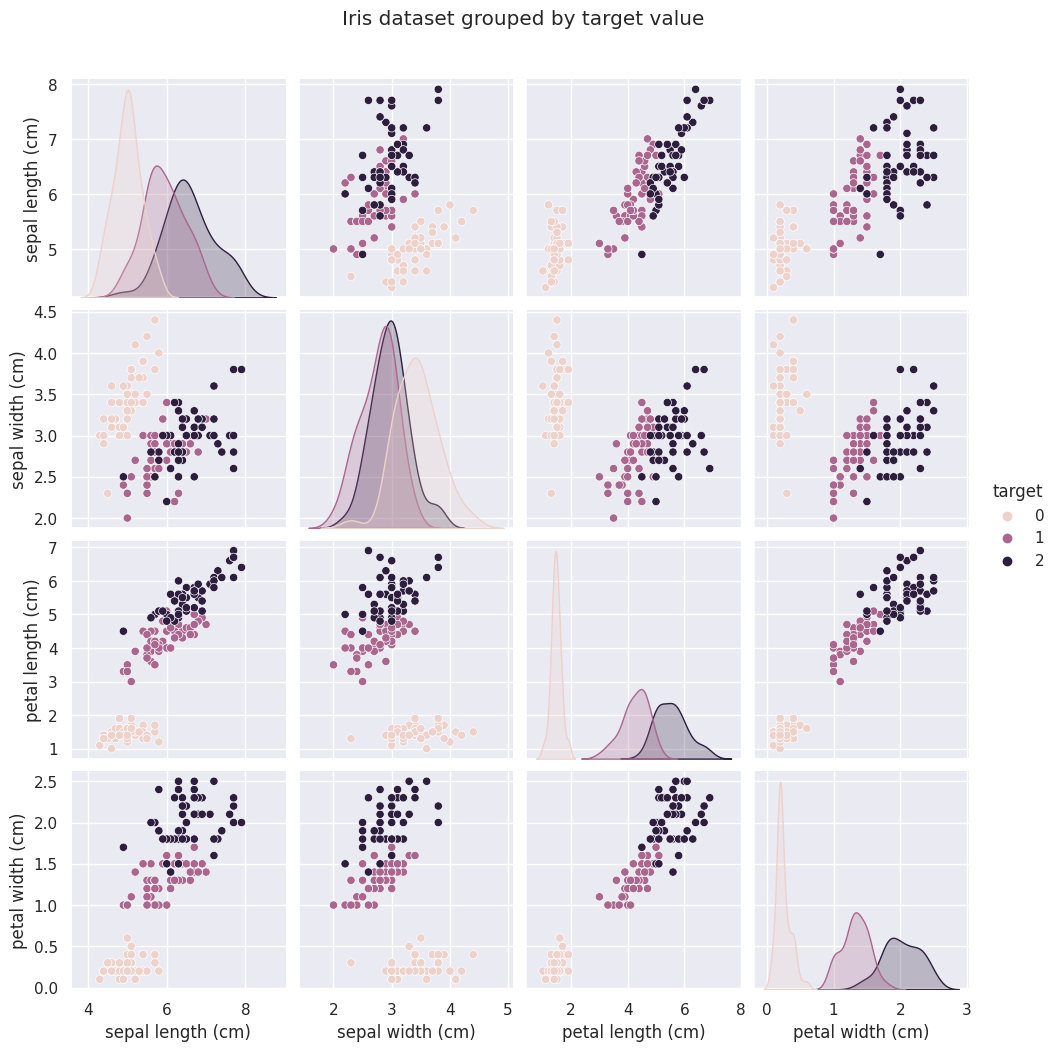

In [61]:
g2 = sns.pairplot(data=iris_cah,kind='scatter',hue='CAH_Petal')
g2.fig.suptitle("CAH clustering using only two features", y=1.05)
gt = sns.pairplot(data=iris,kind='scatter',hue='target')
gt.fig.suptitle("Iris dataset grouped by target value", y=1.05)

# CAH Using all features

In [62]:
columns_to_study = iris.columns
cah_all = CAH(iris,columns_to_study)
cah_all.df.head()

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  
0       0  
1       0  
2       0  
3       0  
4       0

In [63]:
cah_all.scale(StandardScaler())
cah_all.df_mean_std

0    1    2    3    4
mean -0.0 -0.0 -0.0 -0.0 -0.0
std   1.0  1.0  1.0  1.0  1.0

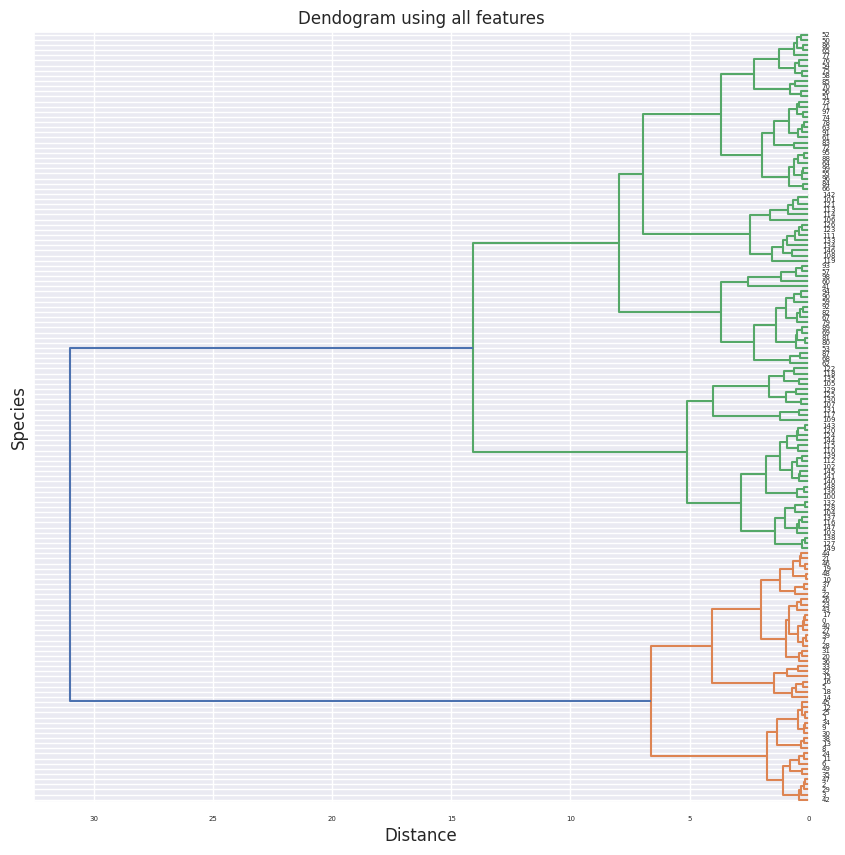

In [64]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
cah_all.dendrogram(ax,"Dendogram using all features","Distance","Species",labelsize=5)

In [65]:
cah_all.cluster(3)
iris_cah_all = iris_values.copy()
iris_cah_all["CAH_All"] = cah_all.clusters

Comparing the two dendograms, side by side.

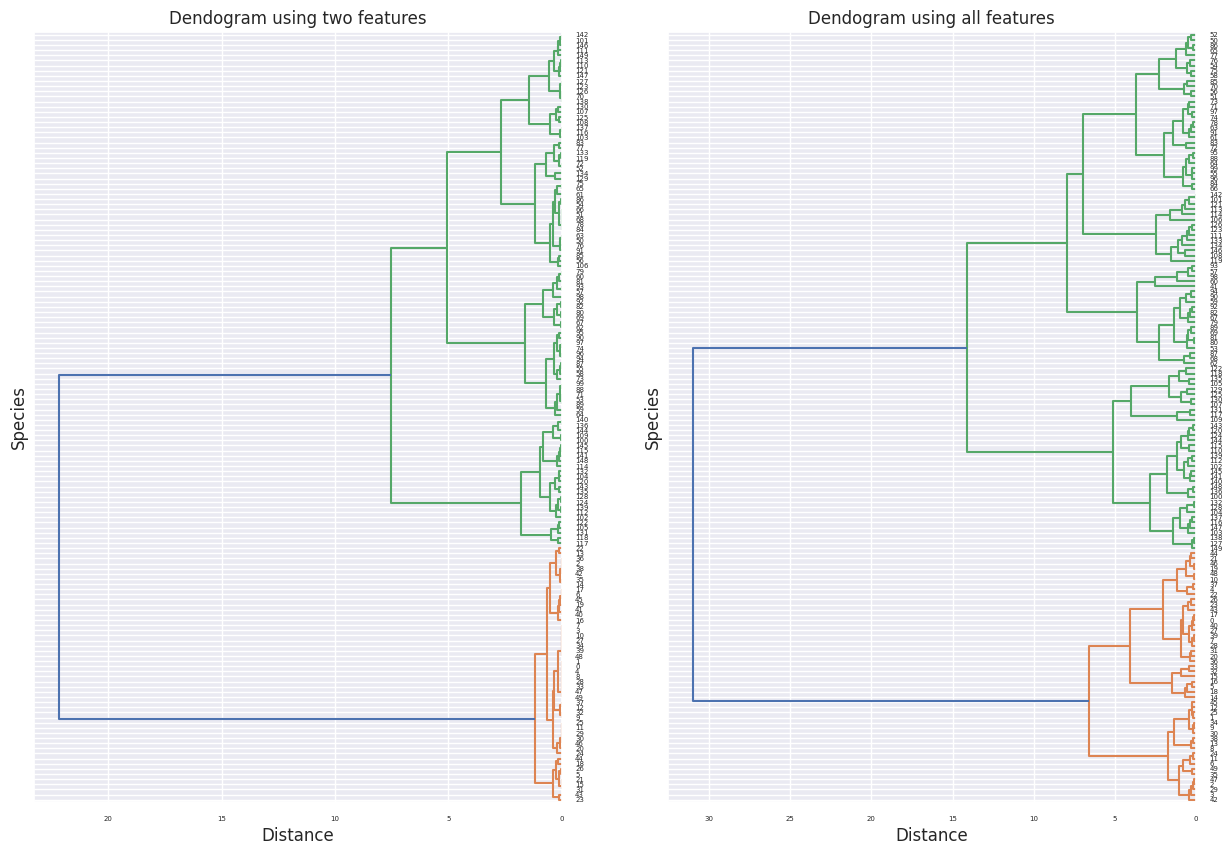

In [66]:
fig, ax = plt.subplots(1,2,figsize=(15,10))
cah_petal.dendrogram(ax[0],"Dendogram using two features","Distance","Species",labelsize=5)
cah_all.dendrogram(ax[1],"Dendogram using all features","Distance","Species",labelsize=5)

Text(0.5, 1.05, 'CAH clustering using all features')

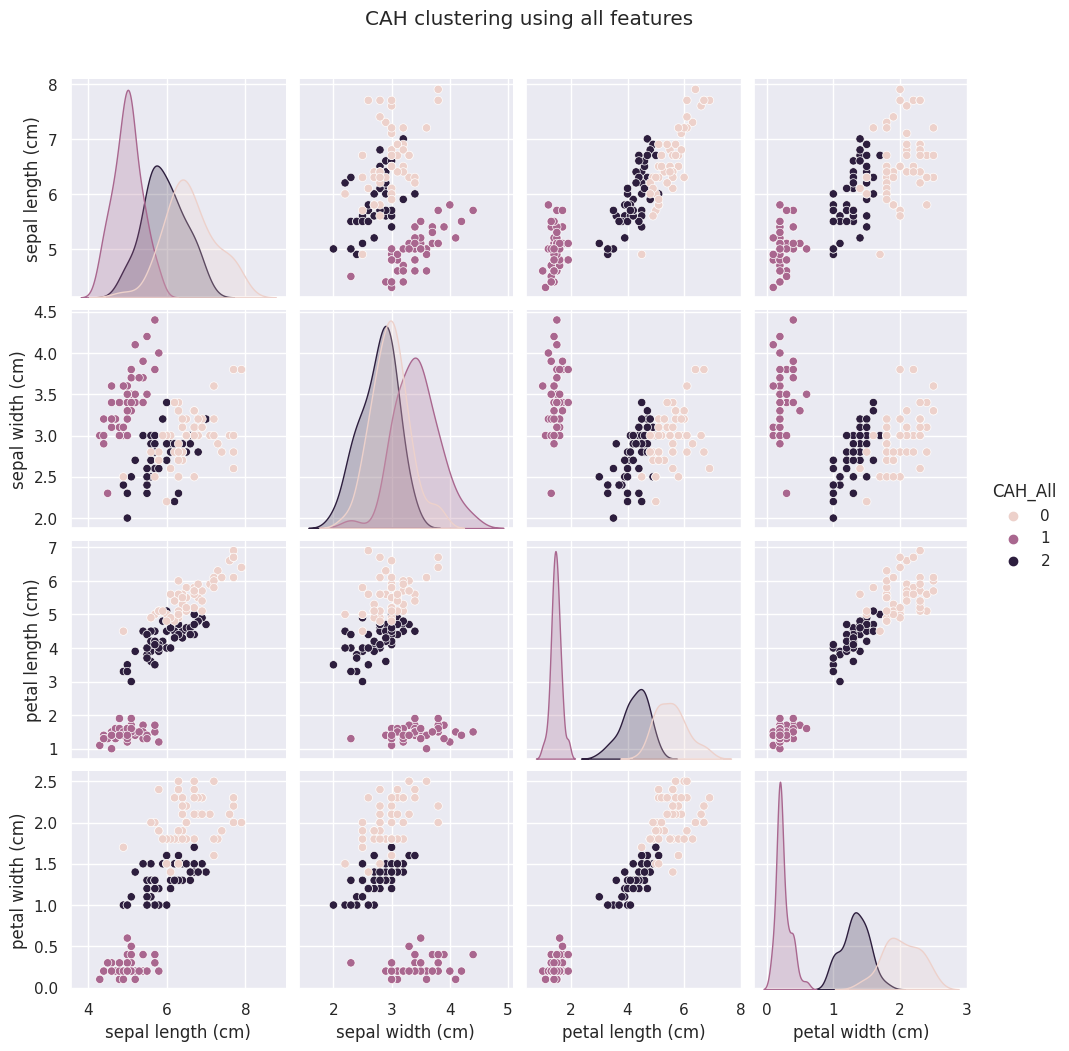

In [67]:
g_all = sns.pairplot(data=iris_cah_all,kind='scatter',hue='CAH_All')
g_all.fig.suptitle("CAH clustering using all features", y=1.05)

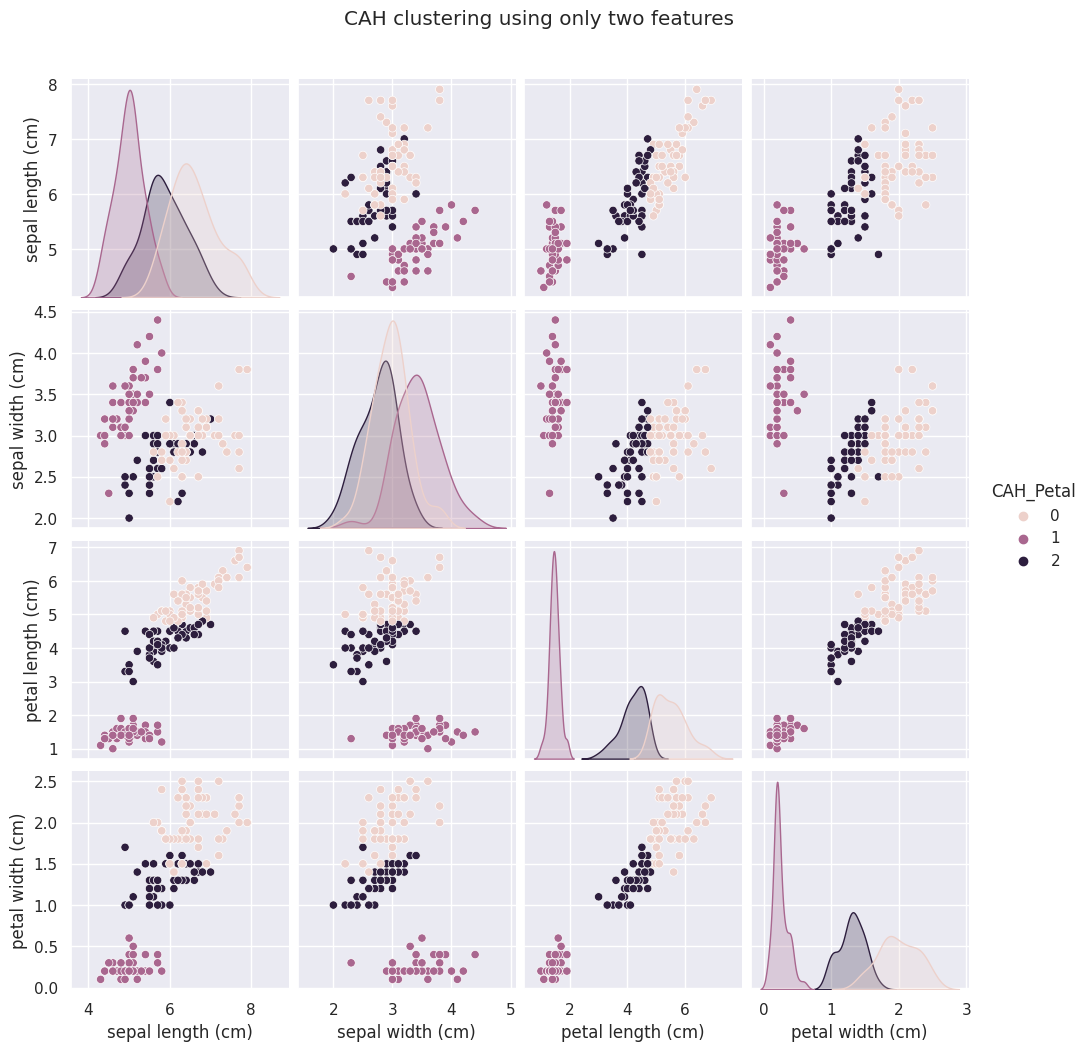

In [68]:
g2.fig

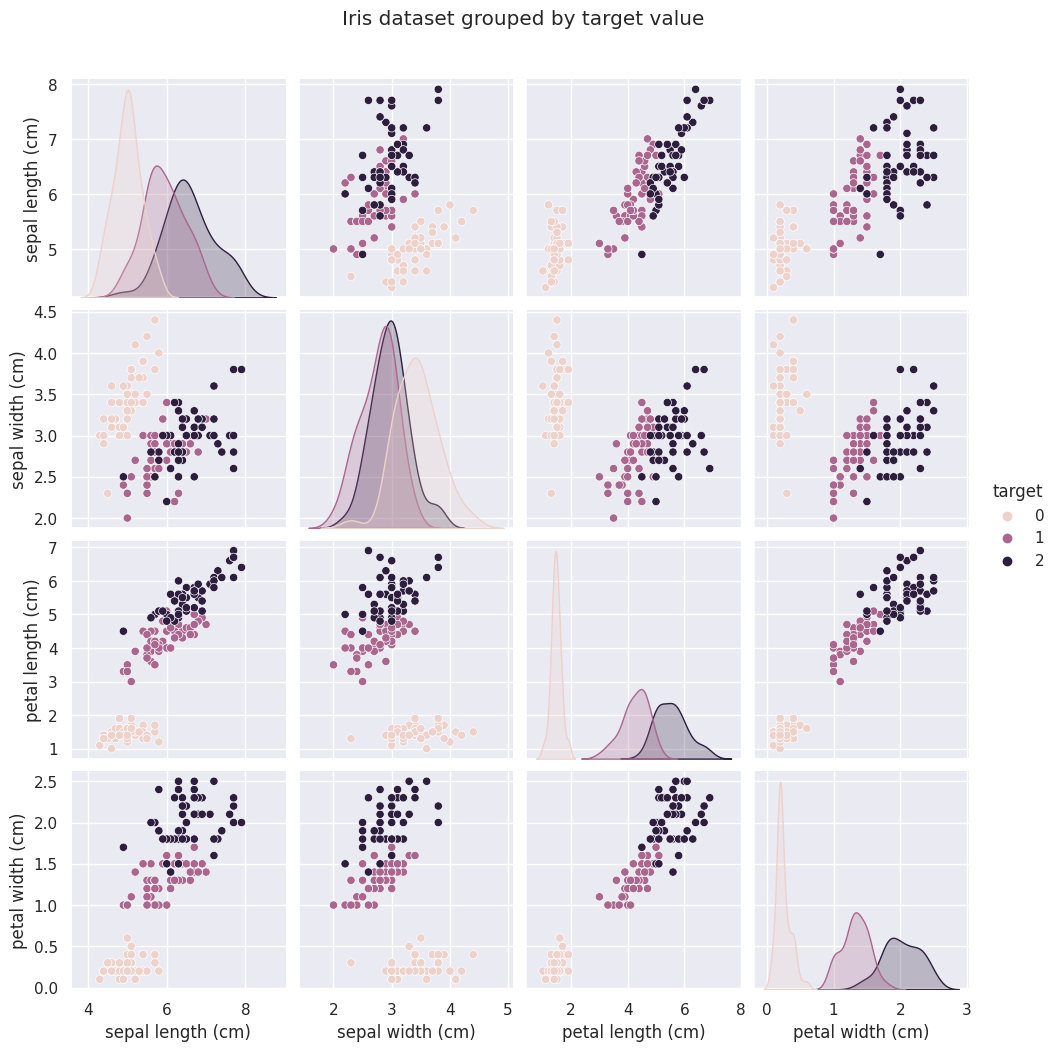

In [69]:
gt.fig

# K-Means
## Class

In [170]:
class kmeans :
    def __init__(self,df,columns):
        self.df = df[columns]
        self.colmuns = columns
        self.cluster = []
            
    def plot_inertia(self,ax,title,k_max=10):
        '''This function plots the inertia for each k value, from 2 to k_max. Using the elbow method will help choosing the best k value.
        Subplot should be created before calling this function, providing the ax parameter.
            input: ax, title, k_max
            output: plot
        '''
        inertia_list = []
        X = self.df.values
        for k in range(1,k_max):
            kmeans = KMeans(n_clusters=k, n_init='auto')
            
            kmeans.fit(X)
            
            inertia_list.append(kmeans.inertia_)
        ax.set_title(title)
        ax.set_xlabel("n_clusters")
        ax.set_ylabel("inertia")
        ax = plt.plot(range(1,k_max), inertia_list)
        
    def plot_silhouette(self, ax,k_list):
        '''This function plots the silhouette score for each k value, specifiy in k_list. 
        Using the silhouette score will help choosing the best k value.
        '''
        X = self.df.values
        for k in k_list:
            if k < 2:
                print("k must be greater than 1")
            else:
                ax[k-2].set_title("Silhouette plot for k = {}".format(k))
                kmeans = KMeans(n_clusters=k, n_init='auto')
                kmeans.fit(X)
                
                score = silhouette_score(self.df.values, kmeans.labels_)
                print("For n_clusters = {}, silhouette score is {:.3f})".format(k, score))
                
                visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=ax[k-2])
                visualizer.fit(X)

    def kmean_choose (self,n_clusters):
        '''This function clusters the data using the number of clusters provided as input. This number is chosen by the user reviewing the inertia plot.
            Define : clusters
        '''
        X = self.df.values
        
        kmeans = KMeans(n_clusters=n_clusters, n_init='auto')
        
        kmeans.fit(X)
        
        self.clusters = kmeans.labels_

## Usage
We will study the class usage using all features. We will first create an object **km** and then use the **plot_inertia** methods to use the elbow method to find the optimal number of clusters. Then, **plot_silhouette** will be used after to help choose the optimal number of clusters.

In [171]:
columns_to_study = iris.columns
km = kmeans(iris,columns_to_study)

In [172]:
km.df.head()

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  
0       0  
1       0  
2       0  
3       0  
4       0

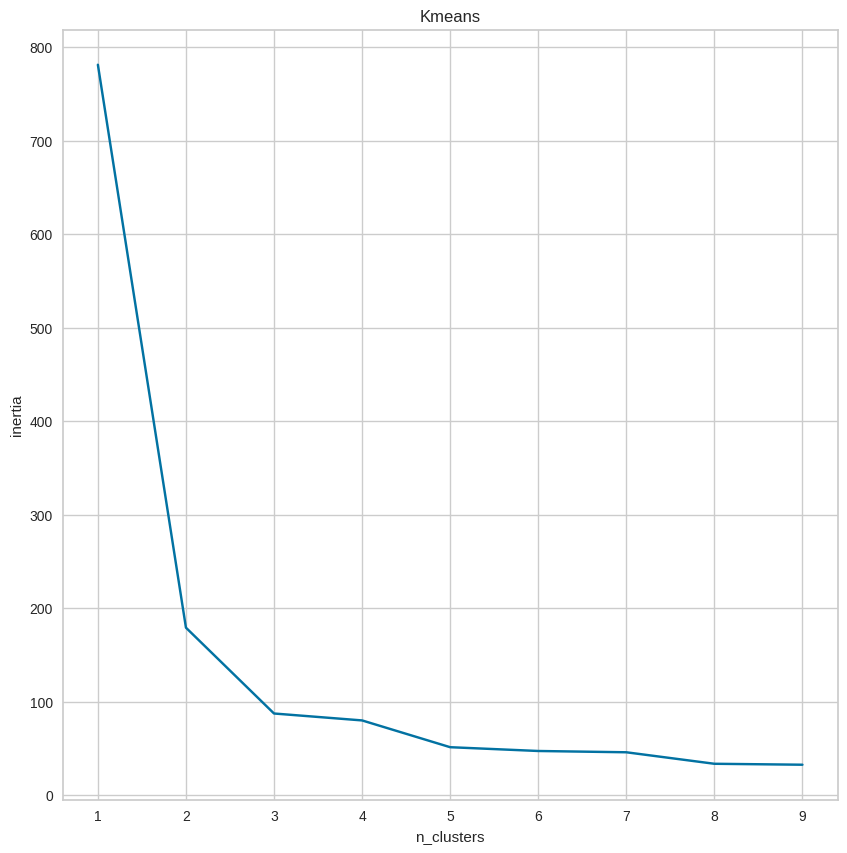

In [173]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
km.plot_inertia(ax,"Kmeans")

The Elbow method is not very clear in this case. The optimal number of cluster could be 3 or 2. We will use the silhouette method to help us choose between the two.

For n_clusters = 2, silhouette score is 0.680)
For n_clusters = 3, silhouette score is 0.579)


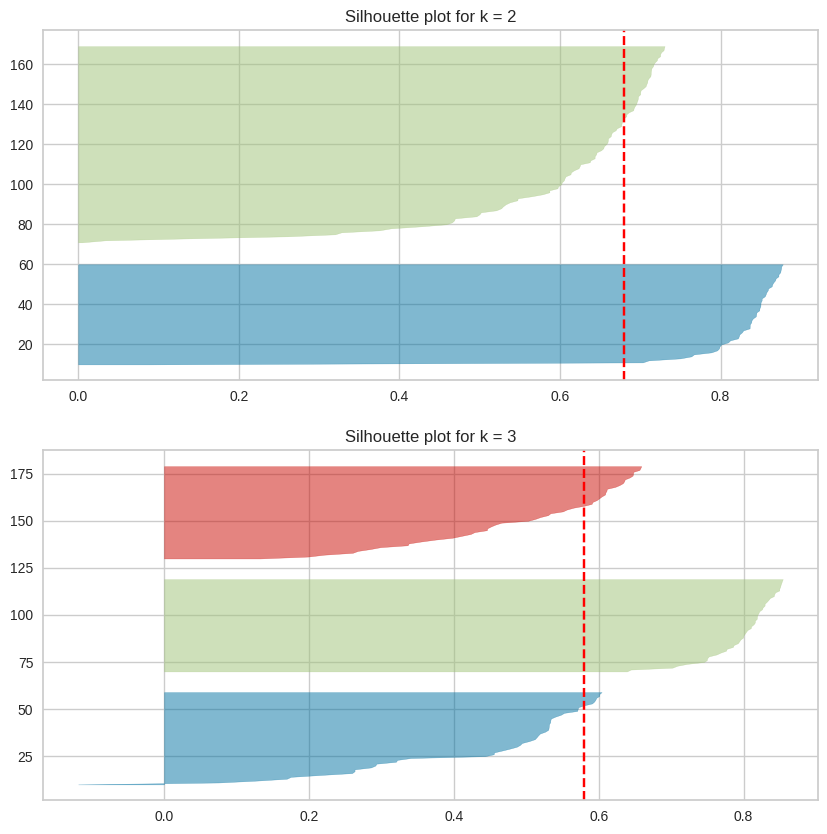

In [174]:
fig, ax = plt.subplots(2,1,figsize=(10,10))
km.plot_silhouette(ax,[2,3])

Using the silhouette method, we can see a better repartition of the clusters for *k=3*. The three clusters also reach a higher silhouette score than the average silhouette score. We will therefore use *k=3*.
___

Just for the sake of showing how we could use the class, we will now cluster the data with two *k-values*. **Therefore, we know that the optimal number of clusters is 3**. We will use *k=2* and *k=3*.

In [175]:
km.kmean_choose(3)
cluster3 = km.clusters
iris_kmeans3 = iris_values.copy()
iris_kmeans3["cluster"] = cluster3

In [176]:
km.kmean_choose(2)
cluster2 = km.clusters
iris_kmeans2 = iris_values.copy()
iris_kmeans2["cluster"] = cluster2

Text(0.5, 1.05, 'Iris dataset with target')

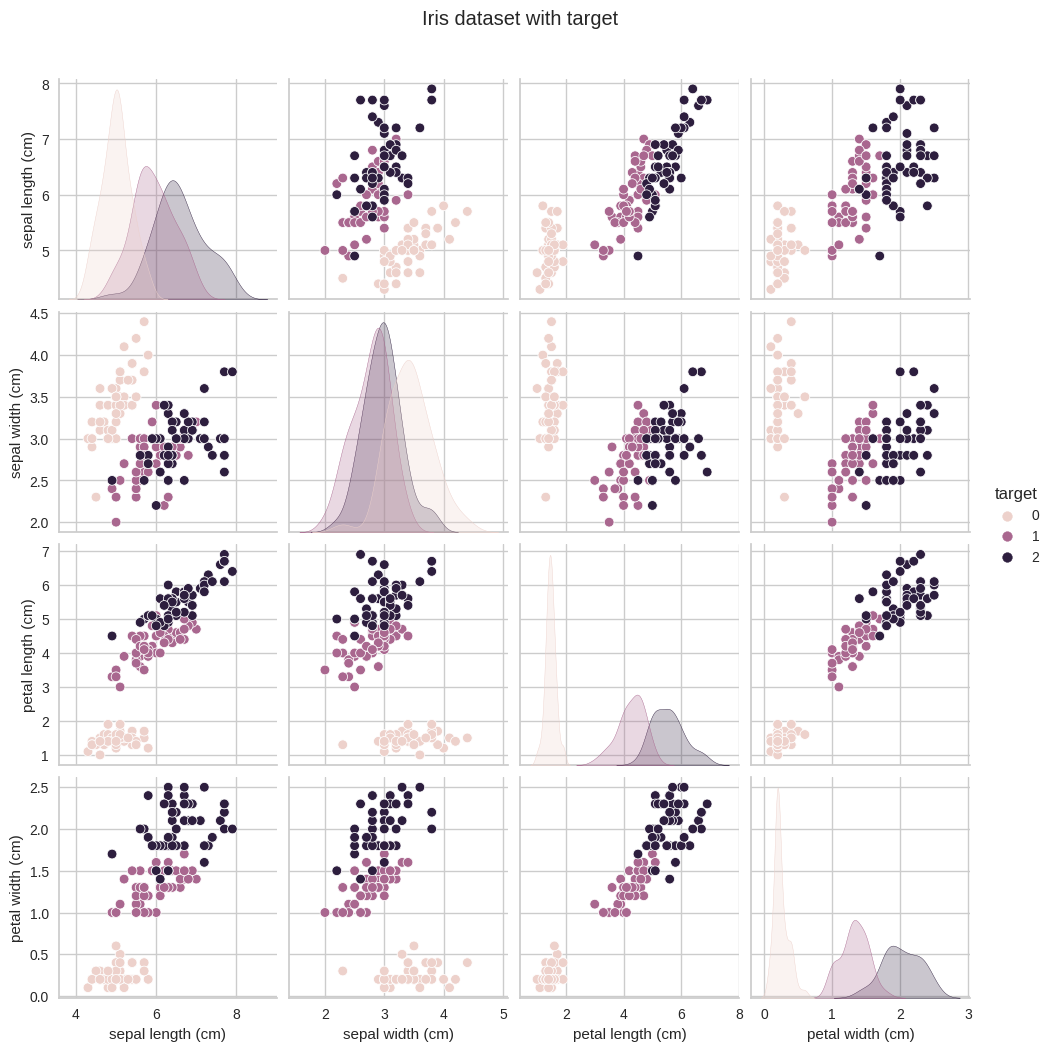

In [177]:
g = sns.pairplot(data=iris,kind='scatter',hue='target')
g.fig.suptitle("Iris dataset with target",y=1.05)

Text(0.5, 1.05, 'Iris dataset with n_cluster = 2')

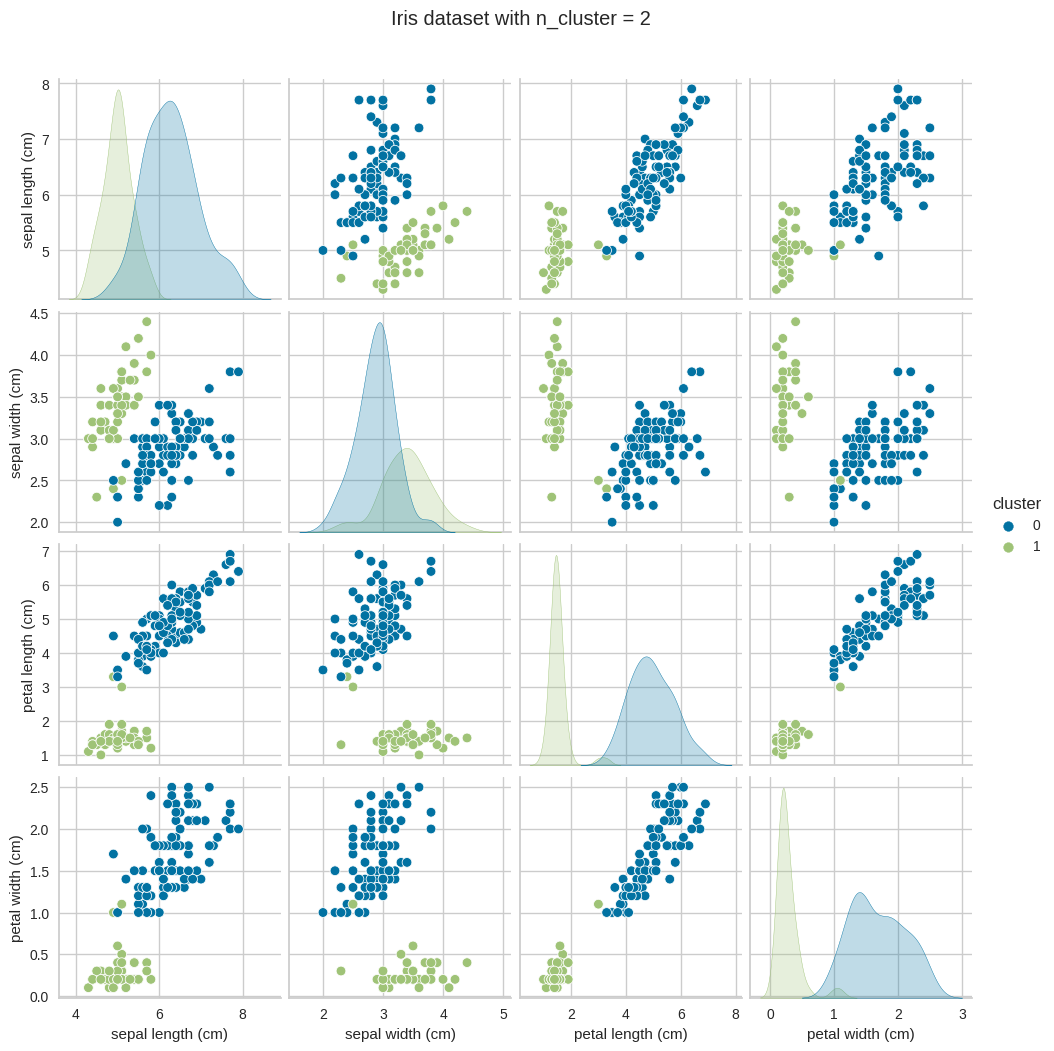

In [178]:
g = sns.pairplot(data=iris_kmeans2,kind='scatter',hue='cluster')
g.fig.suptitle("Iris dataset with n_cluster = 2",y=1.05)

Text(0.5, 1.05, 'Iris dataset with n_clusters = 3')

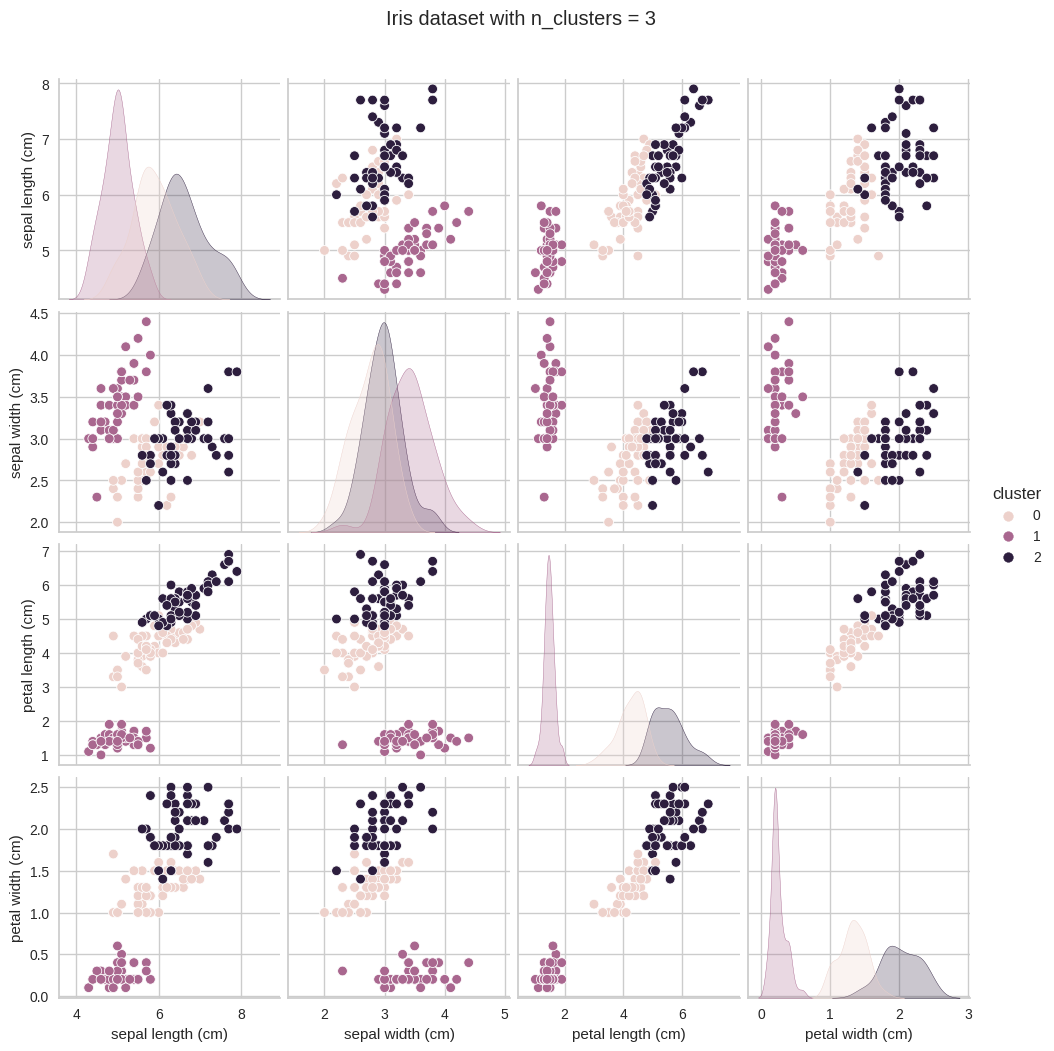

In [179]:
g = sns.pairplot(data=iris_kmeans3,kind='scatter',hue='cluster')
g.fig.suptitle("Iris dataset with n_clusters = 3",y=1.05)